# Classification

## MNIST

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

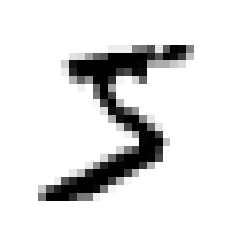

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_img = some_digit.reshape(28, 28)

plt.imshow(some_digit_img, cmap='binary')
plt.axis('off')
plt.show()

In [4]:
y[0]

'5'

In [7]:
import numpy as np

y = y.astype(np.uint8)

y[0]

5

In [8]:
# MNIST is already split into training and test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier
For start let's make a binary classifier that will indentify single digit - digit 5.

In [9]:
y_train_5, y_test_5 = (y_train == 5), (y_test == 5)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

#### Implementing Cross-Validation
Following code is roughly equivalent to *Scikit-Learn*'s function `cross_val_score`.

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_ix, test_ix in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train[train_ix]
    y_train_folds = y_train_5[train_ix]
    
    X_test_folds = X_train[test_ix]
    y_test_folds = y_train_5[test_ix]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = np.sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

This seems pretty good! However, let's check a classifier that always classifies an image as **not 5**.

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

Over 90% accuracy! Well, the problem is that just about 10% of the whole dataset are images of 5 (there are 10 numbers in total). Hence the 90% accuracy.

### Confusion Matrix
The idea of a *confusion matrix* is to count the number of times class A is classified as class B and so on. 

To compute the confusion matrix one must first get predicions (here on the train set, let's keep test set aside). We can take predictions for a cross-validation with `cross_val_predict` and pass them to `confusion_matrix`.

For a binary classification the confusion matrix looks like this:

|     | N  | P  |
|-----|----|----|
| N   | TN | FP |
| P   | FN | TP |

Rows are the *actual* class and columns are the predicted class, furthermore
* *P* - *positive* (class)
* *N* - *negative* (class)
* *TN* - *true negative*
* *TP* - *true positive*
* *FN* - *false negative*
* *FP* - *false negative*

In [15]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [17]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])